In [2]:
from dask import distributed

c = distributed.Client()

In [3]:
import xarray as xr
import xarray_regrid

In [4]:
ds_vars = xr.open_zarr(
    "gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3",
    chunks=None,
    storage_options={"token": "anon"},
)

ds = xr.open_zarr(
    "gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3",
    chunks={"time": 1, "latitude": -1, "longitude": -1},
    storage_options={"token": "anon"},
    drop_variables=[v for v in ds_vars.data_vars if v != "sea_surface_temperature"],
)

ar_full_37_1h = ds.sel(
    time=slice(ds.attrs["valid_time_start"], ds.attrs["valid_time_stop"])
)
ar_full_37_1h

<xarray.Dataset> Size: 3TB
Dimensions:                  (latitude: 721, level: 37, longitude: 1440,
                              time: 741456)
Coordinates:
  * latitude                 (latitude) float32 3kB 90.0 89.75 ... -89.75 -90.0
  * level                    (level) int64 296B 1 2 3 5 7 ... 925 950 975 1000
  * longitude                (longitude) float32 6kB 0.0 0.25 ... 359.5 359.8
  * time                     (time) datetime64[ns] 6MB 1940-01-01 ... 2024-07...
Data variables:
    sea_surface_temperature  (time, latitude, longitude) float32 3TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    valid_time_start:  1940-01-01
    last_updated:      2024-10-17 20:04:10.783634
    valid_time_stop:   2024-07-31

In [5]:
ds_reduced = ar_full_37_1h.sel(
    latitude=slice(70, -70, 4), longitude=slice(150, 240, 4), time=slice("1960", "2020")
).isel(time=slice(None, None, 36))
ds_reduced = ds_reduced.chunk({"time": 30, "latitude": -1, "longitude": -1})


In [6]:
ds_grid = xarray_regrid.Grid(
    north=70,
    south=-70,
    east=240,
    west=150,
    resolution_lat=5,
    resolution_lon=5
).create_regridding_dataset()

In [7]:
sst_regrid = ds_reduced["sea_surface_temperature"].sortby(["latitude", "longitude"]).regrid.stat(ds_grid, method="mean")

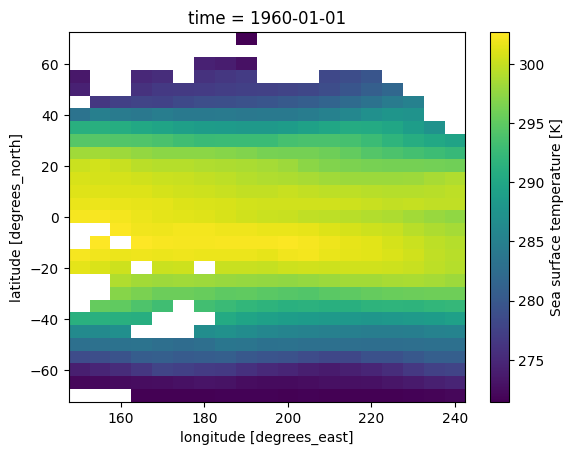

In [8]:
sst_regrid.isel(time=0).plot()

In [9]:
sst_regrid.load()

<xarray.DataArray 'sea_surface_temperature' (time: 14854, latitude: 29,
                                             longitude: 19)> Size: 33MB
array([[[      nan,       nan,       nan, ..., 271.6233 , 271.7445 ,
         271.95648],
        [271.98624, 272.10074, 272.34778, ..., 273.65158, 274.17517,
         274.57367],
        [274.1253 , 274.7368 , 275.31702, ..., 276.5282 , 277.5473 ,
         277.8041 ],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ..., 271.63495, 271.7651 ,
         271.9971 ],
        [272.0205 , 272.13953, 272.38553, ..., 273.69604, 274.22104,
         274.60175],
        [274.18942, 274.7888 , 275.3627 , ..., 276.5853 , 277.62314,
         277.87842],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ..., 271.50873, 271.46014,
         271.46024],
        [272.44394, 272.43512, 272.37698, ..., 272.51797, 272.69067,
         273.0245 ],
        [273.58987, 274.3841 , 274.91327, ..., 275.4167 , 275.92075,
         275.89713],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 119kB 1960-01-01 ... 2020-12-30T12:00:00
  * latitude   (latitude) int64 232B -70 -65 -60 -55 -50 -45 ... 50 55 60 65 70
  * longitude  (longitude) int64 152B 150 155 160 165 170 ... 225 230 235 240
Attributes:
    long_name:   Sea surface temperature
    short_name:  sst
    units:       K

In [10]:

import lilio
import urllib
import xarray as xr
from s2spy import preprocess
from s2spy import RGDR
import numpy as np
import onnxruntime as ort

In [11]:
# create custom calendar based on the time of interest
calendar = lilio.Calendar(anchor="08-01", allow_overlap=True)
# add target periods
calendar.add_intervals("target", length="30d")
# add precursor periods
periods_of_interest = 8
calendar.add_intervals("precursor", "1M", gap="1M", n=periods_of_interest)

In [12]:
def load_data(url, field, var):
    '''Download a netCDF file from a URL and open a variable as xr.DataArray.'''
    url_field = url + field
    urllib.request.urlretrieve(url_field, field)
    dataset = xr.open_dataset(field)
    dataarray = dataset[var]
    return dataarray 

In [13]:
# URL of the dataset from zenodo
url = "https://zenodo.org/record/8186914/files/"

sst_field = "sst_daily_1959-2021_5deg_Pacific_175_240E_25_50N.nc" # Pacific Ocean SST
t2m_field = "t2m_daily_1959-2021_2deg_clustered_226_300E_30_70N.nc" # Southwestern USA T2M

In [14]:
precursor_field = load_data(url, sst_field, "sst")
target_field = load_data(url, t2m_field, "t2m").sel(cluster=3)

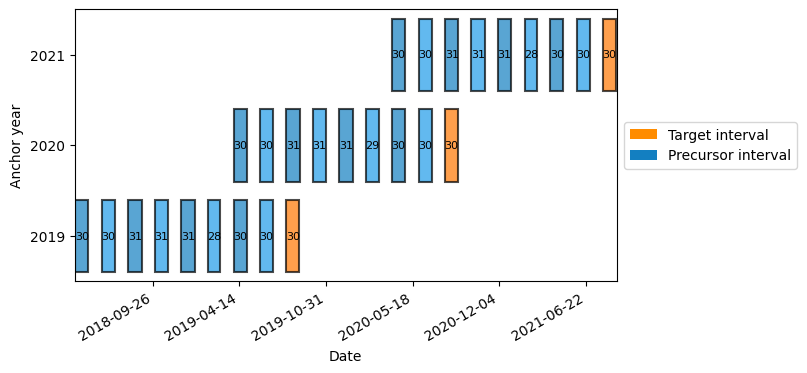

In [15]:
calendar.map_to_data(precursor_field)
calendar.visualize(show_length=True)

In [16]:
# get 60% of instance as training
years = sorted(calendar.get_intervals().index)
train_samples = round(len(years) * 0.6)
test_samples = round(len(years) * 0.2)
start_year = years[0]

In [17]:
# create preprocessor
preprocessor = preprocess.Preprocessor(
    rolling_window_size=25,
    timescale="monthly",
    detrend="linear",
    subtract_climatology=True,
)

# fit preprocessor with training data
preprocessor.fit(
    precursor_field.sel(
        time=slice(str(start_year), str(start_year + train_samples - 1))
    )
)

/Users/clairedonnelly/AI4S2S/.venv/lib/python3.10/site-packages/s2spy/preprocess.py:155: UserWarning: The temporal resolution of data does not completely match the target timescale. Please check your input data.
  warnings.warn(


In [18]:
# preprocess the whole precursor field
precursor_field_prep = preprocessor.transform(precursor_field)

In [19]:
precursor_field_resample = lilio.resample(calendar, precursor_field_prep)
target_field_resample = lilio.resample(calendar, target_field)

In [26]:
import torch
from torch import nn
import sys 
import time as tt
import wandb


sys.path.append("../src/")
from transformer import Transformer
import utils

ERROR: Could not find a version that satisfies the requirement time (from versions: none)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
ERROR: No matching distribution found for time
Note: you may need to restart the kernel to use updated packages.


In [21]:
# slice and reshape input desired by transformer
sequence_precursor = len(precursor_field_resample.i_interval) - 1 # we only take precursor parts of i intervals
lat_precursor = len(precursor_field_resample.latitude)
lon_precursor = len(precursor_field_resample.longitude)

X_torch = torch.from_numpy(precursor_field_resample[:,:-1,:,:].data).type(torch.FloatTensor)
y_torch = torch.from_numpy(target_field_resample[:,-1].data).type(torch.FloatTensor)

X_torch = X_torch.view(-1, sequence_precursor, lat_precursor*lon_precursor)
y_torch = y_torch.unsqueeze(1).unsqueeze(1).repeat(1, 1, lat_precursor*lon_precursor)

# turn nan to 0.0
X_torch = torch.nan_to_num(X_torch, 0.0)

In [22]:
# train/validate/test split and use pytorch dataloader
train_X_torch = X_torch[:train_samples]
train_y_torch = y_torch[:train_samples]

valid_X_torch = X_torch[train_samples:train_samples + test_samples]
valid_y_torch = y_torch[train_samples:train_samples + test_samples]

test_X_torch = X_torch[-test_samples:]
test_y_torch = y_torch[-test_samples:]

# pytorch train and test sets
train_set = torch.utils.data.TensorDataset(train_X_torch, train_y_torch)
valid_set = torch.utils.data.TensorDataset(valid_X_torch, valid_y_torch)
test_set = torch.utils.data.TensorDataset(test_X_torch, test_y_torch)

In [23]:
print ("Pytorch version {}".format(torch.__version__))
use_cuda = torch.cuda.is_available()
print("Is CUDA available? {}".format(use_cuda))
# use GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device to be used for computation: {}".format(device))

Pytorch version 2.5.1
Is CUDA available? False
Device to be used for computation: cpu


In [47]:
# call weights & biases service
#wandb.login()

hyperparameters = dict(
    epoch = 30,
    num_encoder_layers = 1,
    num_decoder_layers = 1,
    dim_model = lat_precursor*lon_precursor,
    num_heads = 2,
    dim_feedforward = 12,
    batch_size = 4,
    dropout = 0.1,
    learning_rate = 0.01,
    periods_of_interest = periods_of_interest,
    dataset = 'Weather',
    architecture = 'Transformer'
)

# initialize weights & biases service
#mode = 'online'
mode = 'disabled'
wandb.init(config=hyperparameters, project='test-transformer', entity='ai4s2s', mode=mode)
config = wandb.config

In [48]:
# create data loader and use batch 
train_loader = torch.utils.data.DataLoader(train_set, batch_size = config.batch_size, shuffle = False)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = config.batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = config.batch_size, shuffle = False)

In [49]:
# Initialize model
model = Transformer(num_encoder_layers = config["num_encoder_layers"],
                    num_decoder_layers = config["num_decoder_layers"],
                    dim_model = config["dim_model"], 
                    num_heads = config["num_heads"], 
                    dim_feedforward = config["dim_feedforward"], 
                    dropout = config["dropout"])
# Specify loss function
criterion = nn.MSELoss()
# Choose optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
# Print model and optimizer details
print('Model details:\n', model)
print('Optimizer details:\n',optimizer)
wandb.watch(model)

Model details:
 Transformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (attention): Residual(
          (sublayer): MultiHeadAttention(
            (heads): ModuleList(
              (0-1): 2 x AttentionHead(
                (q): Linear(in_features=65, out_features=32, bias=True)
                (k): Linear(in_features=65, out_features=32, bias=True)
                (v): Linear(in_features=65, out_features=32, bias=True)
              )
            )
            (linear): Linear(in_features=64, out_features=65, bias=True)
          )
          (norm): LayerNorm((65,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): Residual(
          (sublayer): Sequential(
            (0): Linear(in_features=65, out_features=12, bias=True)
            (1): ReLU()
            (2): Linear(in_features=12, out_features=65, bias=True)
          )
          (norm): LayerNorm

In [50]:
utils.total_num_param(model)

58905


In [51]:
# calculate the time for the code execution
start_time = tt.time()

# switch model into training mode
model.train()

hist_train = []
hist_valid = []
for epoch in range(config.epoch):
    # training loop
    # switch model into train mode
    model.train()
    hist_train_step = 0
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        var_X_batch = torch.autograd.Variable(X_batch).to(device)
        var_y_batch = torch.autograd.Variable(y_batch).to(device)
        optimizer.zero_grad()
        # note: decoder input is the last instance of encoder input
        output = model(var_X_batch, var_X_batch.clone()[:,-1:,:])
        loss = criterion(output, var_y_batch)
        loss.backward()
        optimizer.step()
        wandb.log({'train_loss': loss.item()})
        if batch_idx % 2 == 0:
            print(f'Epoch : {epoch} [{batch_idx*len(X_batch)}/{len(train_loader.dataset)}'
                  f'({100.* batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
        hist_train_step += loss.item()

    hist_train.append(hist_train_step / len(train_loader.dataset))

    # cross-validation loop
    # switch model into evaluation mode
    model.eval()
    hist_valid_step = 0

    for batch_idx, (X_batch, y_batch) in enumerate(valid_loader):
        var_X_batch = torch.autograd.Variable(X_batch).to(device)
        var_y_batch = torch.autograd.Variable(y_batch).to(device)
        optimizer.zero_grad()
        with torch.no_grad():
            output = model(var_X_batch, var_X_batch.clone()[:,-1:,:])
            loss = criterion(output, var_y_batch)
        wandb.log({'validation_loss': loss.item()})
        hist_valid_step += loss.item()

    hist_valid.append(hist_valid_step / len(valid_loader.dataset))

print (f"--- {(tt.time() - start_time)/60} minutes ---")

Epoch : 0 [0/37(0%)]	Loss: 87624.460938
Epoch : 0 [8/37(20%)]	Loss: 87087.039062
Epoch : 0 [16/37(40%)]	Loss: 86157.335938
Epoch : 0 [24/37(60%)]	Loss: 85526.140625
Epoch : 0 [32/37(80%)]	Loss: 84897.453125
Epoch : 1 [0/37(0%)]	Loss: 84024.968750
Epoch : 1 [8/37(20%)]	Loss: 83159.132812
Epoch : 1 [16/37(40%)]	Loss: 81948.273438
Epoch : 1 [24/37(60%)]	Loss: 80924.328125
Epoch : 1 [32/37(80%)]	Loss: 79961.476562
Epoch : 2 [0/37(0%)]	Loss: 78584.929688
Epoch : 2 [8/37(20%)]	Loss: 77457.320312
Epoch : 2 [16/37(40%)]	Loss: 75830.945312
Epoch : 2 [24/37(60%)]	Loss: 74435.617188
Epoch : 2 [32/37(80%)]	Loss: 73008.484375
Epoch : 3 [0/37(0%)]	Loss: 71344.914062
Epoch : 3 [8/37(20%)]	Loss: 69757.507812
Epoch : 3 [16/37(40%)]	Loss: 67814.539062
Epoch : 3 [24/37(60%)]	Loss: 66035.390625
Epoch : 3 [32/37(80%)]	Loss: 64196.437500
Epoch : 4 [0/37(0%)]	Loss: 62194.851562
Epoch : 4 [8/37(20%)]	Loss: 60262.648438
Epoch : 4 [16/37(40%)]	Loss: 58016.015625
Epoch : 4 [24/37(60%)]	Loss: 55870.253906
Epoch :

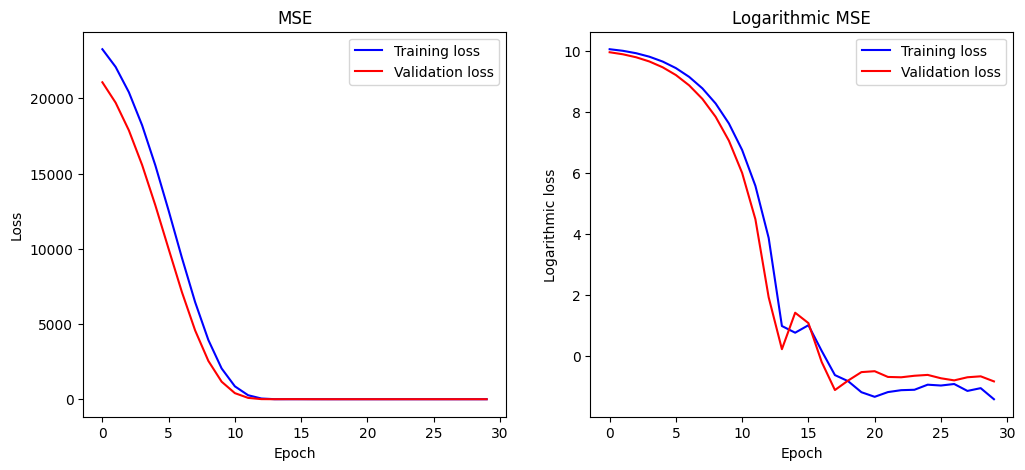

In [52]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))
fig.add_subplot(1, 2, 1)
plt.plot(np.asarray(hist_train), 'b', label="Training loss")
plt.plot(np.asarray(hist_valid), 'r', label="Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("MSE")
plt.legend()

fig.add_subplot(1, 2, 2)
plt.plot(np.log(np.asarray(hist_train)), 'b', label="Training loss")
plt.plot(np.log(np.asarray(hist_valid)), 'r', label="Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Logarithmic loss')
plt.title("Logarithmic MSE")
plt.legend()

plt.show()

In [53]:
# save the checkpoint model training
from pathlib import Path

output_path = Path.cwd().parent / "models"
output_path.mkdir(parents=True, exist_ok=True)

checkpoint_path = output_path / 'transformer_train_checkpoint.pt'

torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item()
            }, checkpoint_path)

In [54]:
# switch model into evaluation mode
model.eval()
hist_test = []
predictions = []
hist_test_step = 0
for batch_idx, (X_batch, y_batch) in enumerate(test_loader):
    var_X_batch = torch.autograd.Variable(X_batch).to(device)
    var_y_batch = torch.autograd.Variable(y_batch).to(device)
    optimizer.zero_grad()
    with torch.no_grad():
        output = model(var_X_batch, var_X_batch.clone()[:,-1:,:])
        loss = criterion(output, var_y_batch)
    wandb.log({'testing_loss': loss.item()})
    predictions.append(torch.mean(output.squeeze(), dim=1).cpu().detach().numpy())
    hist_test_step += loss.item()

hist_test.append(hist_test_step / len(test_loader.dataset))
# call wandb finish to stop logging
wandb.finish()

The MSE loss is 0.365


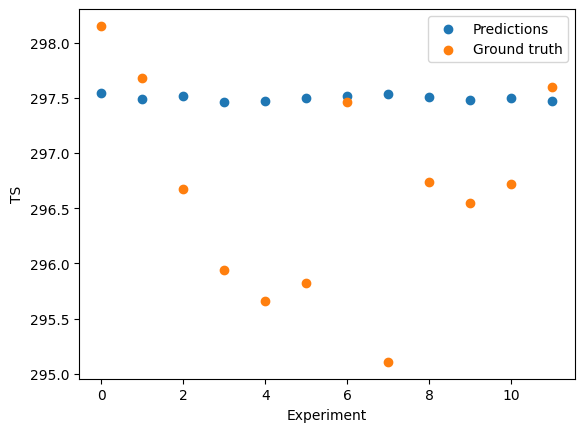

In [55]:
print(f"The MSE loss is {hist_test[0]:.3f}")

fig = plt.figure()
instances = np.arange(len(np.concatenate(predictions)))
plt.scatter(instances, np.concatenate(predictions), label="Predictions")
plt.scatter(instances, np.mean(test_y_torch.squeeze().numpy(), 1), label="Ground truth")
plt.xlabel("Experiment")
plt.ylabel("TS")
plt.legend()
plt.show()